In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('../Style.mplstyle')
import pandas as pd
import os
import sys
import scipy
from scipy import stats
import matplotlib.dates as mdates
from datetime import datetime
from iminuit import Minuit
sys.path.append('..')
from read_data_functions import *
from plot_functions import *
from calculations import *

In [2]:
parent_path = '../../../../'
path = 'L:/PG-Nanoteknologi/Data/MA200/Raw data/visibuilt_day1 2024/'
path_field = 'L:/PG-Nanoteknologi/PROJEKTER/2024 Laura og Nan/cph central and nørreport measurements/'
path_screening = 'L:/PG-Nanoteknologi/PROJEKTER/2024 Laura og Nan/pilot kbh hovedbanegaard and noerregade/rawdata/particle/ma200/'

data = read_csv_BC(path, parent_path, 0)

HEPA_keys = ['MA200-0285_240910101601', 'MA200-0353_240910103200', 'MA200-0369_240910101605']
conc_keys = ['Sample temp (C)', 'Sample RH (%)', 'Sample dewpoint (C)', 
             'UV BCc', 'Blue BCc', 'Green BCc', 'Red BCc', 'IR BCc']
ylabels = ['Sample T / $^{\circ}$C', 'Sample RH / %', 'Sample DP / $^{\circ}$C', 
           'UV BC / $\mu$g m$^{-3}$', 'Blue BC / $\mu$g m$^{-3}$', 'Green BC / $\mu$g m$^{-3}$', 
           'Red BC / $\mu$g m$^{-3}$', 'IR BC / $\mu$g m$^{-3}$']
colors = ['tab:red', 'tab:blue', 'tab:cyan', 'darkviolet', 'blue', 'green', 'red', 'k']
line_styles = ['-', ':', '--']

mask = data['MA200-0285_240910101601']['IR BCc'] < 1
data['MA200-0285_240910101601'] = data['MA200-0285_240910101601'][mask]

field1 = read_csv_BC(f'{path_field}/Station 1/MA200/', parent_path, -1)
field2 = read_csv_BC(f'{path_field}/Station 2/MA200/', parent_path, -1)
screening = read_csv_BC(path_screening, parent_path, 0)

field1['MA200-0369_241217094901'] = pd.concat([field1['MA200-0369_241217094901'], field1['MA200-0369_241217101259']], ignore_index=True)

field1_keys = ['MA200-0369_000301200101', 'MA200-0369_241210105000', 'MA200-0369_241211095501', 'MA200-0369_241212094705', 
               'MA200-0369_241213094000', 'MA200-0369_241216103300', 'MA200-0369_241217094901']
field2_keys = ['MA200-0285_241209120400', 'MA200-0285_241210105200', 'MA200-0285_241211093400', 'MA200-0285_241212093100', 
               'MA200-0285_241213092900', 'MA200-0285_241216102104', 'MA200-0285_241217101400']
screening_keys = ['MA200-0285_240917110800', 'MA200-0369_240917110806', 'MA200-0369_240919114800']

c:\Users\B363580\Documents\GitHub\Master-thesis\calibration\..\plot_functions.py:297: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=-45, ha="left")
C:\Users\B363580\AppData\Local\Temp\ipykernel_7188\2754926146.py:12: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  fig.tight_layout()


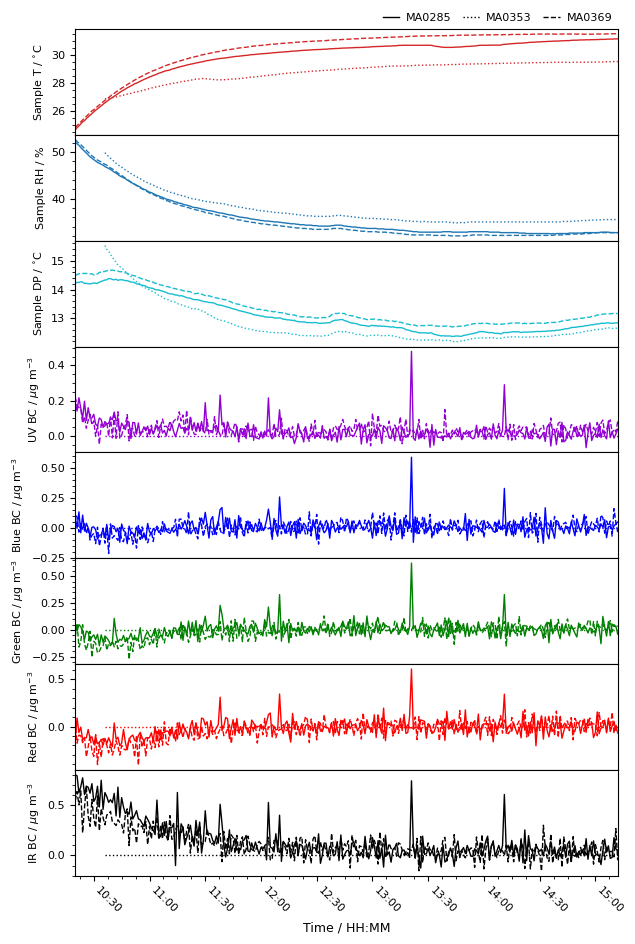

In [3]:
fig = plt.figure(figsize = (7, 11))
gs = fig.add_gridspec(8, hspace=0)
ax = gs.subplots(sharex=True)

for i, df_key in enumerate(conc_keys):
    for ls, dict_key in zip(line_styles, HEPA_keys):
        plot_total(ax[i], data[dict_key], df_key, colors[i], ls)
        ax[i].set_ylabel(ylabels[i], fontsize = 8)

ax[7].legend(labels = ['MA0285', 'MA0353', 'MA0369'], bbox_to_anchor = (0, 7.2, 1, 1), ncol = 3, fontsize = 8)

fig.tight_layout()
fig.savefig('MA200/HEPA_timeseries.png', dpi = 600)

MA0285
UV BCc vs Sample temp (C): f(x) = -0.018650482389122355x + 0.588237503994459, R2 = 0.22967927510745823
UV BCc vs Sample RH (%): f(x) = 0.005545836619956709x + -0.1688729750974447, R2 = 0.22555371418504375
UV BCc vs Sample dewpoint (C): f(x) = 0.036215209969965606x + -0.44294857182582925, R2 = 0.16598409042697873
Blue BCc vs Sample temp (C): f(x) = 0.005281582980178723x + -0.14881795548608512, R2 = 0.01247523839187993
Blue BCc vs Sample RH (%): f(x) = -0.0016904367103395754x + 0.06990511766585805, R2 = 0.014193602544629366
Blue BCc vs Sample dewpoint (C): f(x) = -0.01454379707149911x + 0.19930160322216128, R2 = 0.018130886051990733
Green BCc vs Sample temp (C): f(x) = 0.014945422940302822x + -0.4467341500791928, R2 = 0.08141028965023273
Green BCc vs Sample RH (%): f(x) = -0.004609808474906427x + 0.1659377532935693, R2 = 0.08602066882593533
Green BCc vs Sample dewpoint (C): f(x) = -0.03476829830614106x + 0.454792827069586, R2 = 0.0844447255250793
Red BCc vs Sample temp (C): f(x) =

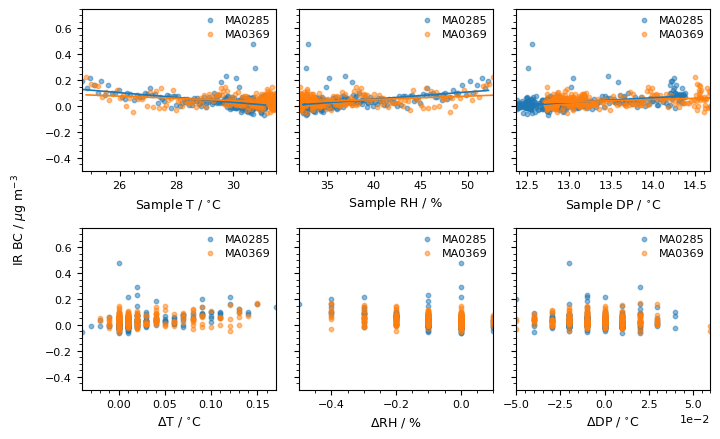

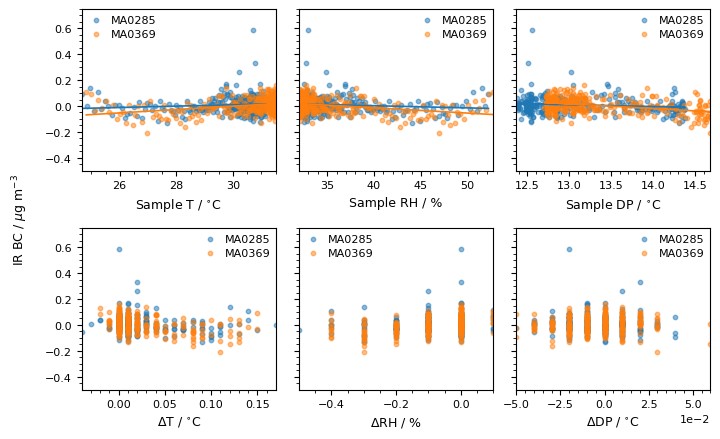

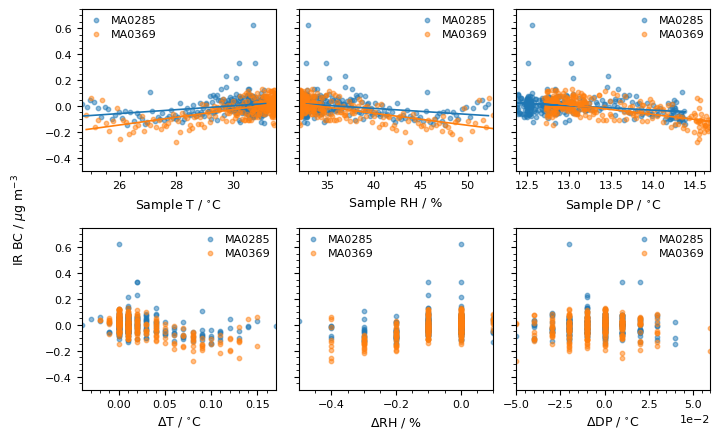

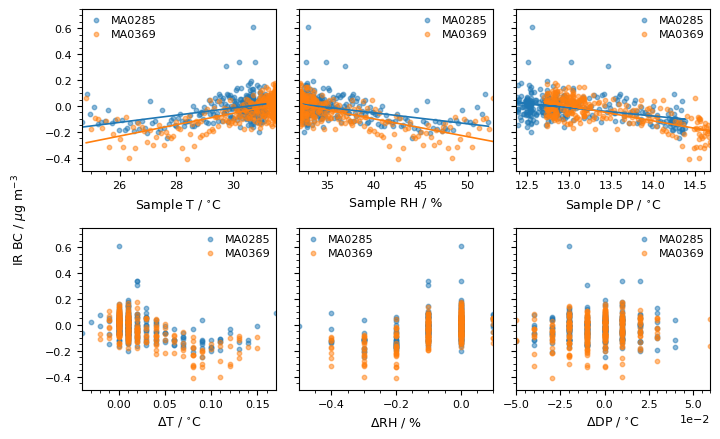

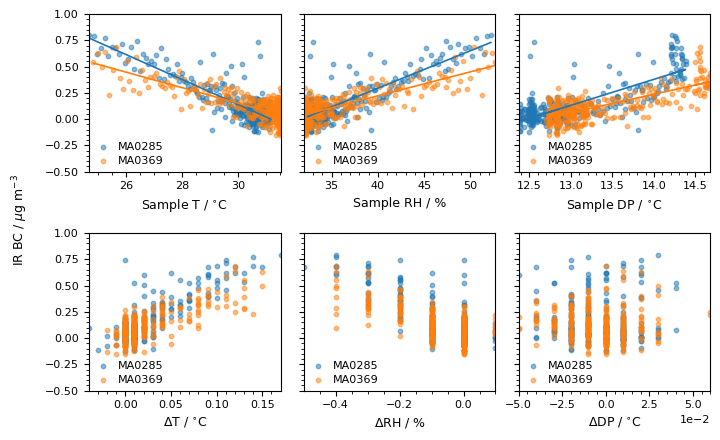

In [4]:
x_labels = [['Sample T / $^{\circ}$C', 'Sample RH / %', 'Sample DP / $^{\circ}$C'],
            ['$\Delta$T / $^{\circ}$C', '$\Delta$RH / %', '$\Delta$DP / $^{\circ}$C']]
guess = [[-0.11, 3.45],
         [0.035, -1.2],
         [0.2, -2.5]]

fig_UV, axs_UV = plt.subplots(2, 3, figsize = (7.3, 4.5), sharey=True)
fig_blue, axs_blue = plt.subplots(2, 3, figsize = (7.3, 4.5), sharey=True)
fig_green, axs_green = plt.subplots(2, 3, figsize = (7.3, 4.5), sharey=True)
fig_red, axs_red = plt.subplots(2, 3, figsize = (7.3, 4.5), sharey=True)
fig_IR, axs_IR = plt.subplots(2, 3, figsize = (7.3, 4.5), sharey=True)
figs = [fig_UV, fig_blue, fig_green, fig_red, fig_IR]
axes = [axs_UV, axs_blue, axs_green, axs_red, axs_IR]

MA0285_a = []
MA0285_b = []
MA0369_a = []
MA0369_b = []

for key, lbl in zip([HEPA_keys[0], HEPA_keys[2]], ['MA0285', 'MA0369']):
    df = data[key]

    print(lbl)

    UVa, UVb, UVR2 = MA_correction_multi(axs_UV, df, conc_keys[:3], 'UV BCc', x_labels, guess, lbl)
    bluea, blueb, blueR2 = MA_correction_multi(axs_blue, df, conc_keys[:3], 'Blue BCc', x_labels, guess, lbl)
    greena, greenb, greenR2 = MA_correction_multi(axs_green, df, conc_keys[:3], 'Green BCc', x_labels, guess, lbl)
    reda, redb, redR2 = MA_correction_multi(axs_red, df, conc_keys[:3], 'Red BCc', x_labels, guess, lbl)
    IRa, IRb, IRR2 = MA_correction_multi(axs_IR, df, conc_keys[:3], 'IR BCc', x_labels, guess, lbl)

    if '285' in lbl:
        MA0285_a.extend([UVa[2], bluea[2], greena[2], reda[2], IRa[2]])
        MA0285_b.extend([UVb[2], blueb[2], greenb[2], redb[2], IRb[2]])

    if '369' in lbl:
        MA0369_a.extend([UVa[2], bluea[2], greena[2], reda[2], IRa[2]])
        MA0369_b.extend([UVb[2], blueb[2], greenb[2], redb[2], IRb[2]])

for axs in axes[:-1]:
    for ax in axs.flatten():
        ax.set_ylim(-0.5, 0.75)
        ax.legend(fontsize = 8)

for ax in axs_IR.flatten():
    ax.set_ylim(-0.5, 1)
    ax.legend(fontsize = 8)

for fig, key in zip(figs, conc_keys[3:]):
    fig.supylabel('IR BC / $\mu$g m$^{-3}$', fontsize = 9)
    fig.tight_layout()

    fig.savefig(f'MA200/{key} corr.png', dpi = 600)

In [5]:
corrected_field1 = get_corrected(f'{path_field}/Station 1/MA200/Korrigeret/', field1, '0369', [MA0369_a, MA0369_b], 'MA200')
corrected_field2 = get_corrected(f'{path_field}/Station 2/MA200/Korrigeret/', field1, '0285', [MA0285_a, MA0285_b], 'MA200')

corrected_screening369 = get_corrected(f'{path_screening}/Korrigeret/', screening, '0369', [MA0369_a, MA0369_b], 'MA200')
corrected_screening285 = get_corrected(f'{path_screening}/Korrigeret/', screening, '0285', [MA0285_a, MA0285_b], 'MA200')